# Pet's Faces Dataset

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [ ]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

Импортируем библиотеки

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm, trange
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

Список категорий

In [2]:
local_dir = os.getcwd()
detaset_dir = os.path.join(local_dir ,'petfaces')
categories = os.listdir(detaset_dir)

Считываем изображения

In [3]:
IMG_SIZE = 50
data = []
for category in tqdm(categories): 
    path = os.path.join(detaset_dir,category) 
    class_num = categories.index(category)
    for img in os.listdir(path): 
        img_array = Image.open(os.path.join(path,img)) 
        img_array = img_array.resize((IMG_SIZE,IMG_SIZE), Image.Resampling.LANCZOS)
        img_array = np.array(img_array)
        data.append([img_array, class_num])

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:03<00:00, 11.32it/s]


Создаем датасеты

In [4]:
random.shuffle(data)
X = []
Y = []

for features,label in data:
    X.append(features)
    Y.append(label)
X = np.array(X) / 255.0
train_x, test_x = np.split(X, [len(X)*8//10])
train_labels, test_labels = np.split(Y, [len(Y)*8//10])
train_x = torch.Tensor(train_x)
train_x = torch.transpose(train_x,1,3)
test_x = torch.Tensor(test_x)
test_x = torch.transpose(test_x,1,3)


train_labels = torch.Tensor(train_labels)
train_labels = train_labels.type(torch.LongTensor)
test_labels = torch.Tensor(test_labels)
test_labels = test_labels.type(torch.LongTensor)

Создам модель

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Sequential(nn.Conv2d(3, 32, 5),nn.ReLU(), nn.MaxPool2d(kernel_size=2,stride = 2)) 
        self.l2 = nn.Sequential( nn.Conv2d(32, 64,5),nn.ReLU(), nn.MaxPool2d(kernel_size=2,stride = 2))
        self.l3 = nn.Sequential( nn.Conv2d(64, 128,4),nn.ReLU(), nn.MaxPool2d(kernel_size=2,stride = 2))
        self.l4 = nn.Conv2d(128,256, 3)
        self.l5 = nn.Flatten()
        self.l6 = nn.Linear(256, 35)
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        x = self.l6(x)
        return x
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr= 0.001)

Тренеруем модель

In [6]:
def Calc_Accuracy(y_pred,y):
    correct = 0
    total = 0
    for i in range(len(y_pred)):
        if torch.argmax(y_pred[i]) == y[i]:
            correct += 1
        total += 1
    return correct/total

In [7]:
EPOCHS = 150
hist_acc_train = []
hist_acc_test = []

for epoch in range(EPOCHS):
    net.zero_grad()
    out_train = net(train_x)
    out_test = net(test_x)
    loss = criterion(out_train, train_labels)
    loss.backward()
    optimizer.step()
    hist_acc_train.append(Calc_Accuracy(out_train,train_labels))
    hist_acc_test.append(Calc_Accuracy(out_test,test_labels))
    print(f"Epoch: {epoch} Loss: {loss} Acc train: {hist_acc_train[-1]} Acc test: {hist_acc_test[-1]}")


Epoch: 0 Loss: 3.5540714263916016 Acc train: 0.021417445482866043 Acc test: 0.02177293934681182
Epoch: 1 Loss: 3.5295827388763428 Acc train: 0.050623052959501556 Acc test: 0.06842923794712286
Epoch: 2 Loss: 3.519324779510498 Acc train: 0.056074766355140186 Acc test: 0.06376360808709176
Epoch: 3 Loss: 3.4952988624572754 Acc train: 0.06425233644859812 Acc test: 0.07153965785381027
Epoch: 4 Loss: 3.482374429702759 Acc train: 0.0646417445482866 Acc test: 0.07309486780715396
Epoch: 5 Loss: 3.447138547897339 Acc train: 0.06113707165109034 Acc test: 0.06687402799377916
Epoch: 6 Loss: 3.3880622386932373 Acc train: 0.06853582554517133 Acc test: 0.07776049766718507
Epoch: 7 Loss: 3.3134024143218994 Acc train: 0.08099688473520249 Acc test: 0.08864696734059098
Epoch: 8 Loss: 3.2363121509552 Acc train: 0.09306853582554517 Acc test: 0.1057542768273717
Epoch: 9 Loss: 3.4512627124786377 Acc train: 0.06269470404984423 Acc test: 0.07309486780715396
Epoch: 10 Loss: 3.24507999420166 Acc train: 0.114485981

Epoch: 87 Loss: 1.369755506515503 Acc train: 0.5915109034267912 Acc test: 0.4494556765163297
Epoch: 88 Loss: 1.3745098114013672 Acc train: 0.5883956386292835 Acc test: 0.4385692068429238
Epoch: 89 Loss: 1.341922640800476 Acc train: 0.5985202492211839 Acc test: 0.4510108864696734
Epoch: 90 Loss: 1.3181480169296265 Acc train: 0.6148753894080997 Acc test: 0.4556765163297045
Epoch: 91 Loss: 1.314025640487671 Acc train: 0.6160436137071651 Acc test: 0.4510108864696734
Epoch: 92 Loss: 1.2887529134750366 Acc train: 0.6203271028037384 Acc test: 0.46500777604976673
Epoch: 93 Loss: 1.273054599761963 Acc train: 0.6277258566978193 Acc test: 0.4758942457231726
Epoch: 94 Loss: 1.2576789855957031 Acc train: 0.6335669781931464 Acc test: 0.46500777604976673
Epoch: 95 Loss: 1.2455830574035645 Acc train: 0.6308411214953271 Acc test: 0.46500777604976673
Epoch: 96 Loss: 1.2254719734191895 Acc train: 0.639797507788162 Acc test: 0.4774494556765163
Epoch: 97 Loss: 1.2033441066741943 Acc train: 0.64291277258566

Точность двоичной классификации "кошки против собак"

In [8]:
def Calc_Accuracy_cat_dog(y_pred,y):
    correct = 0
    total = 0
    for i in range(len(y_pred)):
        pr = (torch.argmax(y_pred[i]) <= 11)
        ans = (y[i] <= 11)
        if pr == ans :
            correct += 1
        total += 1
    return correct/total

In [9]:
out_train = net(train_x)
out_test = net(test_x)

Гравики тренировки

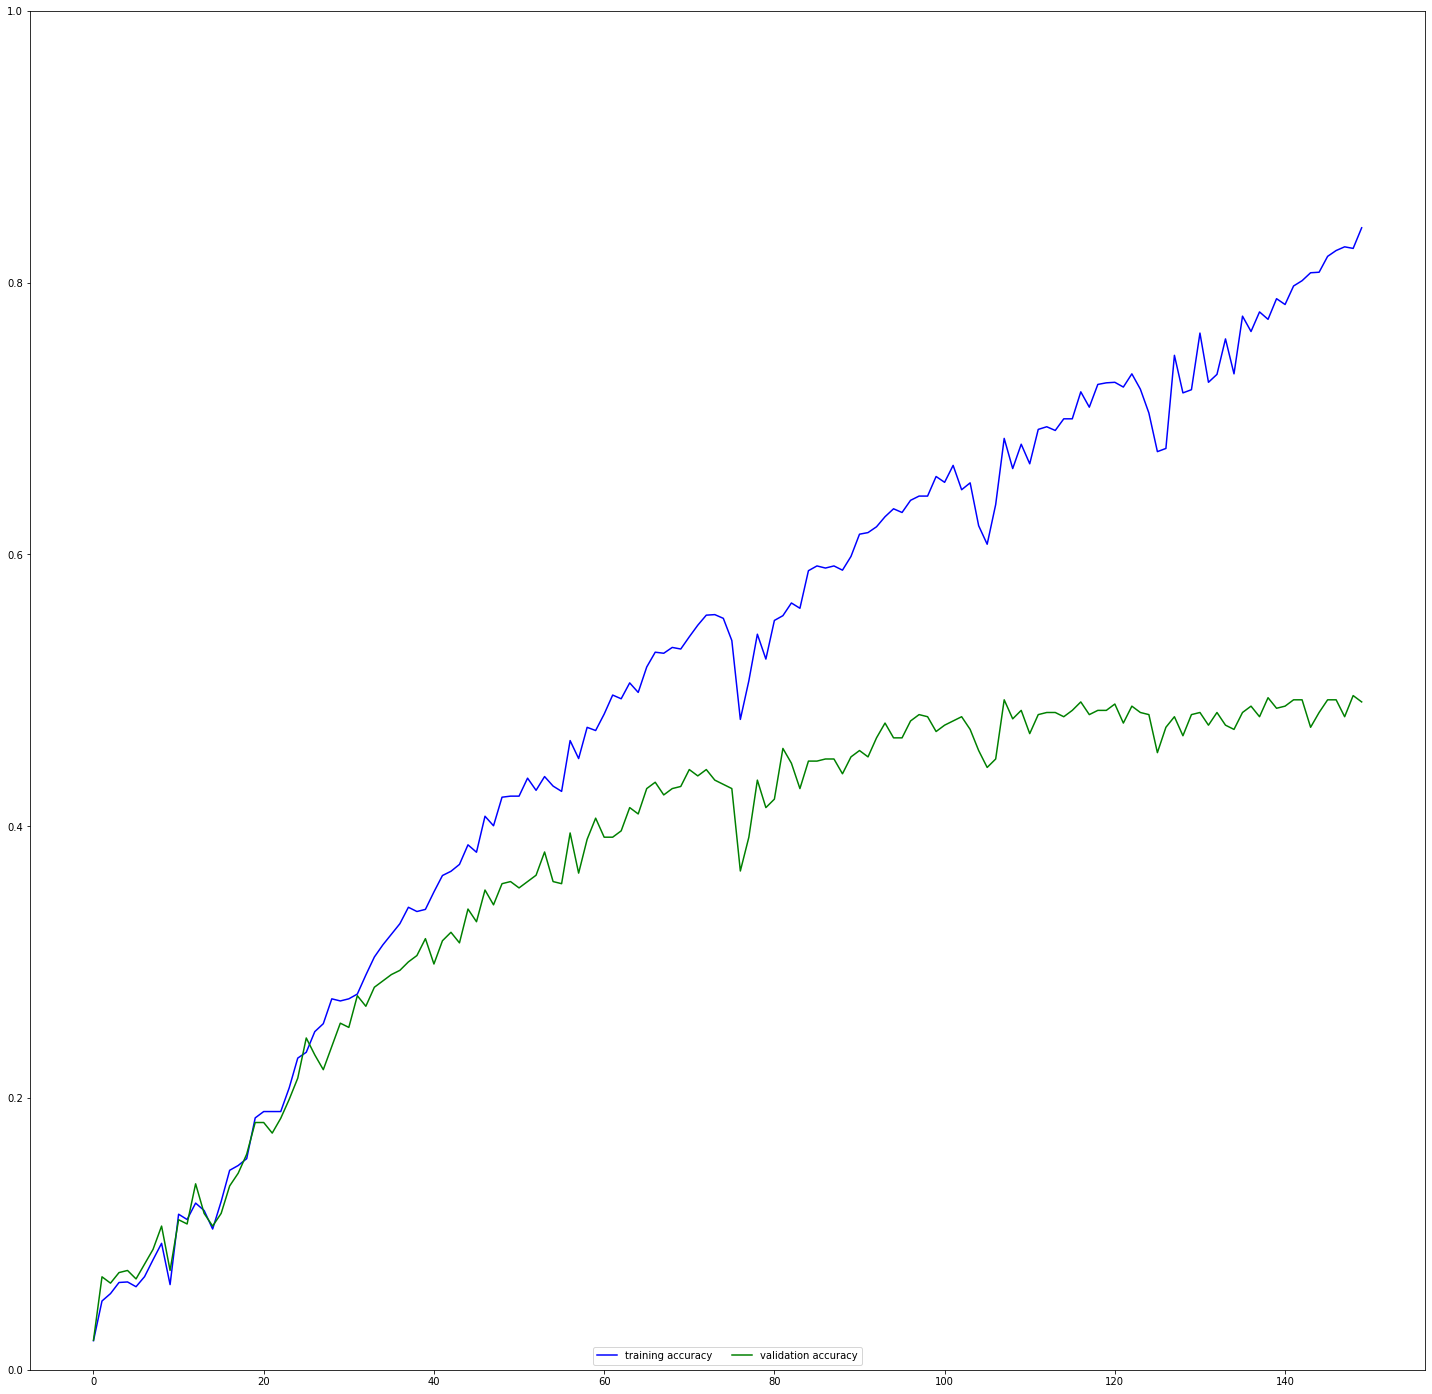

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(25, 25))

ax.plot(list(range(len(list(hist_acc_train)))),hist_acc_train,'-b')
ax.plot(list(range(len(hist_acc_test))),hist_acc_test,'-g')
ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],loc='lower center', ncol = 2)
plt.ylim([0, 1])
plt.show()

In [11]:
print(f"Classification accuracy: {Calc_Accuracy(out_test,test_labels)}")
print(f"Classification cat and dog accuracy: {Calc_Accuracy_cat_dog(out_test,test_labels)}")

Classification accuracy: 0.48522550544323484
Classification cat and dog accuracy: 0.9035769828926905


Сonfusion matrix

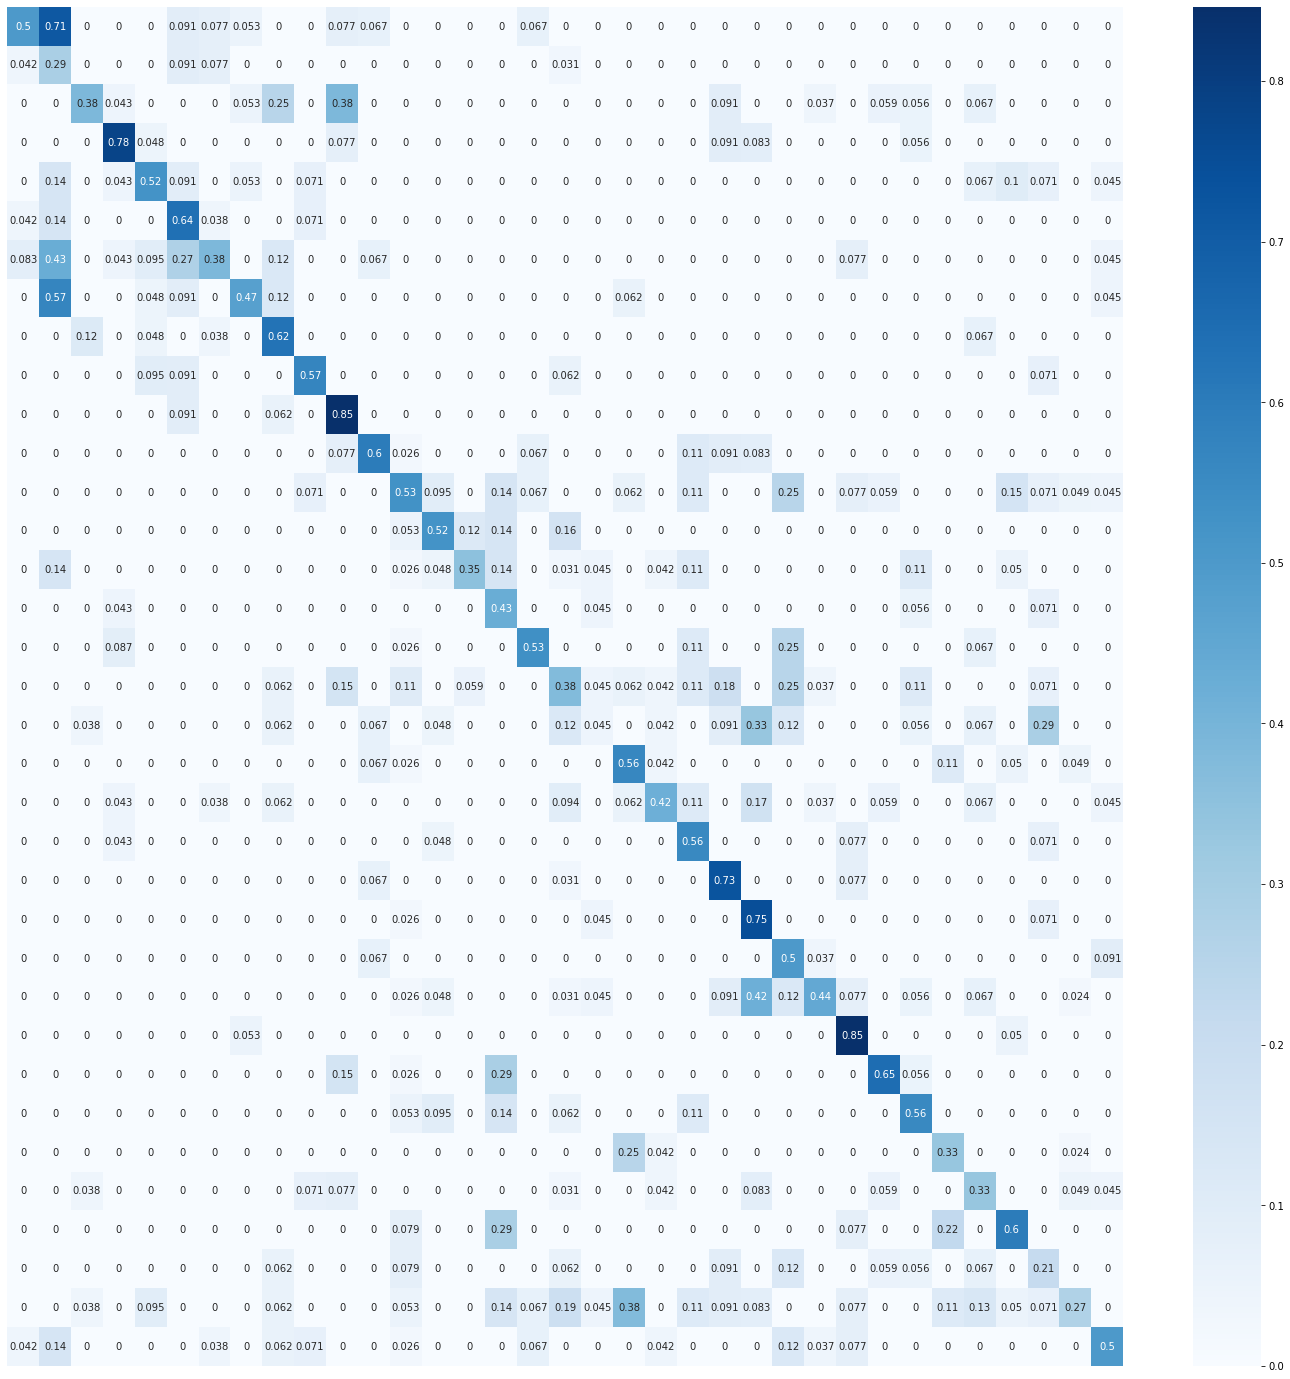

In [12]:
out_test_np = torch.argmax(out_test, axis = 1).detach().numpy()
test_labels_np = test_labels.cpu().detach().numpy()
fig, ax = plt.subplots(figsize=(25, 25))
cf_matrix_all = confusion_matrix(out_test_np, test_labels_np)
cf_matrix_all = cf_matrix_all.astype('float') / cf_matrix_all.sum(axis=1)
sns.heatmap(cf_matrix_all, annot=True, cmap="Blues", ax=ax, yticklabels=False, xticklabels=False)
plt.show()

Сonfusion matrix для двоичной классификации "кошки против собак"

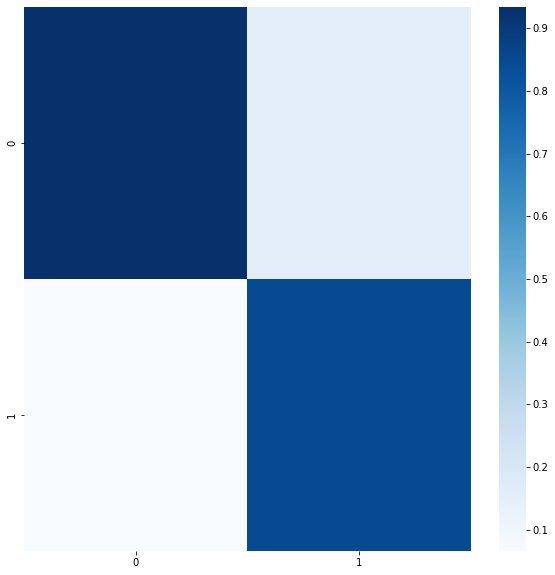

In [13]:
out_test_np = torch.argmax(out_test, axis = 1).detach().numpy()
test_labels_np = test_labels.numpy()

def to_cat_dog(pred):
    l = np.array([])
    for i in pred:
        l = np.append(l, [i <= 11])
    return l

cat_dog_pred = to_cat_dog(out_test_np)
cat_dog_labels = to_cat_dog(test_labels_np)


fig, ax = plt.subplots(figsize=(10, 10))
cf_matrix_cat_dog = confusion_matrix(cat_dog_pred, cat_dog_labels)
cf_matrix_cat_dog = cf_matrix_cat_dog.astype('float') / cf_matrix_cat_dog.sum(axis=0)
sns.heatmap(cf_matrix_cat_dog, annot=False, cmap="Blues", ax=ax)
plt.show()

Top-3 accuracy

In [14]:
acc = np.diag(cf_matrix_all)
top_ind = np.argsort(acc)[:-4:-1]
for i in top_ind:
    print(f'Accuracy {categories[i]}: {acc[i]}')

Accuracy cat_Siamese: 0.8461538461538461
Accuracy dog_pomeranian: 0.8461538461538461
Accuracy cat_Bombay: 0.782608695652174
